### quick start : compare runs, choose a model, and deploy it to a rest api

- run hyperparameter sweep
- compare the result
- chooose a best model
- deploy model to a rest api
- build container image


In [1]:
import keras
import numpy as np
import pandas as pd
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

import mlflow
from mlflow.models import infer_signature


In [2]:

data = pd.read_csv("https://raw.githubusercontent.com/mlflow/mlflow/master/tests/datasets/winequality-white.csv", sep=";")
data


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7


In [3]:
## split the data into training and test sets
train, test = train_test_split(data, test_size=0.2, random_state=7)
train.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
4469,6.4,0.230,0.27,2.1,0.042,35.0,100.0,0.99094,3.03,0.63,10.9,6
3858,6.1,0.210,0.30,6.3,0.039,47.0,136.0,0.99068,3.27,0.31,12.7,6
1422,5.3,0.165,0.24,1.1,0.051,25.0,105.0,0.99250,3.32,0.47,9.1,5
1276,8.0,0.220,0.42,14.6,0.044,45.0,163.0,1.00030,3.21,0.69,8.6,7
398,5.9,0.260,0.27,18.2,0.048,52.0,168.0,0.99930,3.35,0.44,9.4,5


In [4]:
train_x = train.drop(["quality"], axis=1).values
train_y = train[["quality"]].values.ravel()
# Pandas 객체를 직접 넣어도 학습이 되는 상황이 많지만, 특정 상황에서는 형식 문제로 에러가 발생할 수 있습니다. 이 때문에 .values와 .ravel()을 사용하여 명시적으로 NumPy 형식으로 변환하는 것이 권장

## test data
test_x = test.drop(["quality"], axis=1).values
test_y = test[["quality"]].values.ravel()

## split the train data into training and validation sets
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.2, random_state=7)
train_x.shape, valid_x.shape, train_y.shape, valid_y.shape

((3134, 11), (784, 11), (3134,), (784,))

In [5]:
signature = infer_signature(train_x, train_y) # 스키마 알려주기

In [6]:
### ANN model

def train_model(params, epochs, train_x, train_y, valid_x, valid_y, test_x, test_y):
    ## define the model architecture
    mean = np.mean(train_x, axis=0)
    var = np.var(train_x, axis=0)

    model = keras.Sequential([
        keras.Input(shape=(train_x.shape[1],)),
        keras.layers.Normalization(mean=mean, variance=var),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(1)
    ])

    model.compile(optimizer=keras.optimizers.SGD(
        learning_rate=params['lr'], 
        momentum = params['momentum']),
        loss='mean_squared_error',
        metrics=[keras.metrics.RootMeanSquaredError()])

    ## train the ANN model with lr and momentum params with mlflow tracking
    with mlflow.start_run(nested=True):
        model.fit(train_x, train_y, 
                  validation_data=(valid_x, valid_y),
                  batch_size=params['batch_size'], 
                  epochs=epochs, 
                  )


        valid_loss, valid_rmse = model.evaluate(valid_x, valid_y, batch_size=64)

        ## log the metrics
        mlflow.log_params(params)
        mlflow.log_metrics({
            "valid_loss": valid_loss,
            "valid_rmse": valid_rmse,
        })

        ## log the model
        mlflow.tensorflow.log_model(model, "model", signature=signature)

        return {"loss": valid_loss, "status": STATUS_OK, "model": model}

In [14]:
def objective(params):
    result = train_model(
        params,
        epochs=100,
        train_x=train_x,
        train_y=train_y,
        valid_x=valid_x,
        valid_y=valid_y,
        test_x=test_x,
        test_y=test_y
    )
    return result


In [15]:
space = {
    "lr" : hp.loguniform("lr", np.log(1e-5), np.log(1e-1)),
    "momentum" : hp.uniform("momentum", 0.0, 1.0),
    # 더 튜닝할 하이퍼파라미터가 있다면 추가
    "batch_size" : hp.choice("batch_size", [32, 64, 128])
}

In [ ]:
mlflow.set_experiment("/wine_quality/ann_hyperopt")

with mlflow.start_run():
    trials = Trials()
    best = fmin(
        fn=objective,  # 목적 함수
        space=space,   # 하이퍼파라미터 공간
        algo=tpe.suggest,  # 탐색 알고리즘
        max_evals=100,   # 최대 평가 횟수
        trials=trials  # 평가 결과 저장 객체
    )

    best_run = sorted(trials.results, key = lambda x: x['loss'])[0]
    # log the best parameters, loss, and model
    mlflow.log_params(best)
    mlflow.log_metric("valid_rmse", best_run["loss"])
    mlflow.tensorflow.log_model(best_run["model"], "model", signature=signature)

    print("best param", best)
    print("best eval rmse", best_run["loss"])

Epoch 1/100                                            

 1/25 ━━━━━━━━━━━━━━━━━━━━ 3s 165ms/step - loss: 33.8128 - root_mean_squared_error: 5.8149
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 34.4681 - root_mean_squared_error: 5.8709 - val_loss: 34.5636 - val_root_mean_squared_error: 5.8791

Epoch 2/100                                            

 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 34.1214 - root_mean_squared_error: 5.8414
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 34.6775 - root_mean_squared_error: 5.8887 - val_loss: 34.3915 - val_root_mean_squared_error: 5.8644

Epoch 3/100                                            

 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 33.2246 - root_mean_squared_error: 5.7641
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 34.2200 - root_mean_squared_error: 5.8497 - val_loss: 34.2207 - val_root_mean_squared_error: 5.8498

Epoch 4/100                                            

 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 34.3195 - r

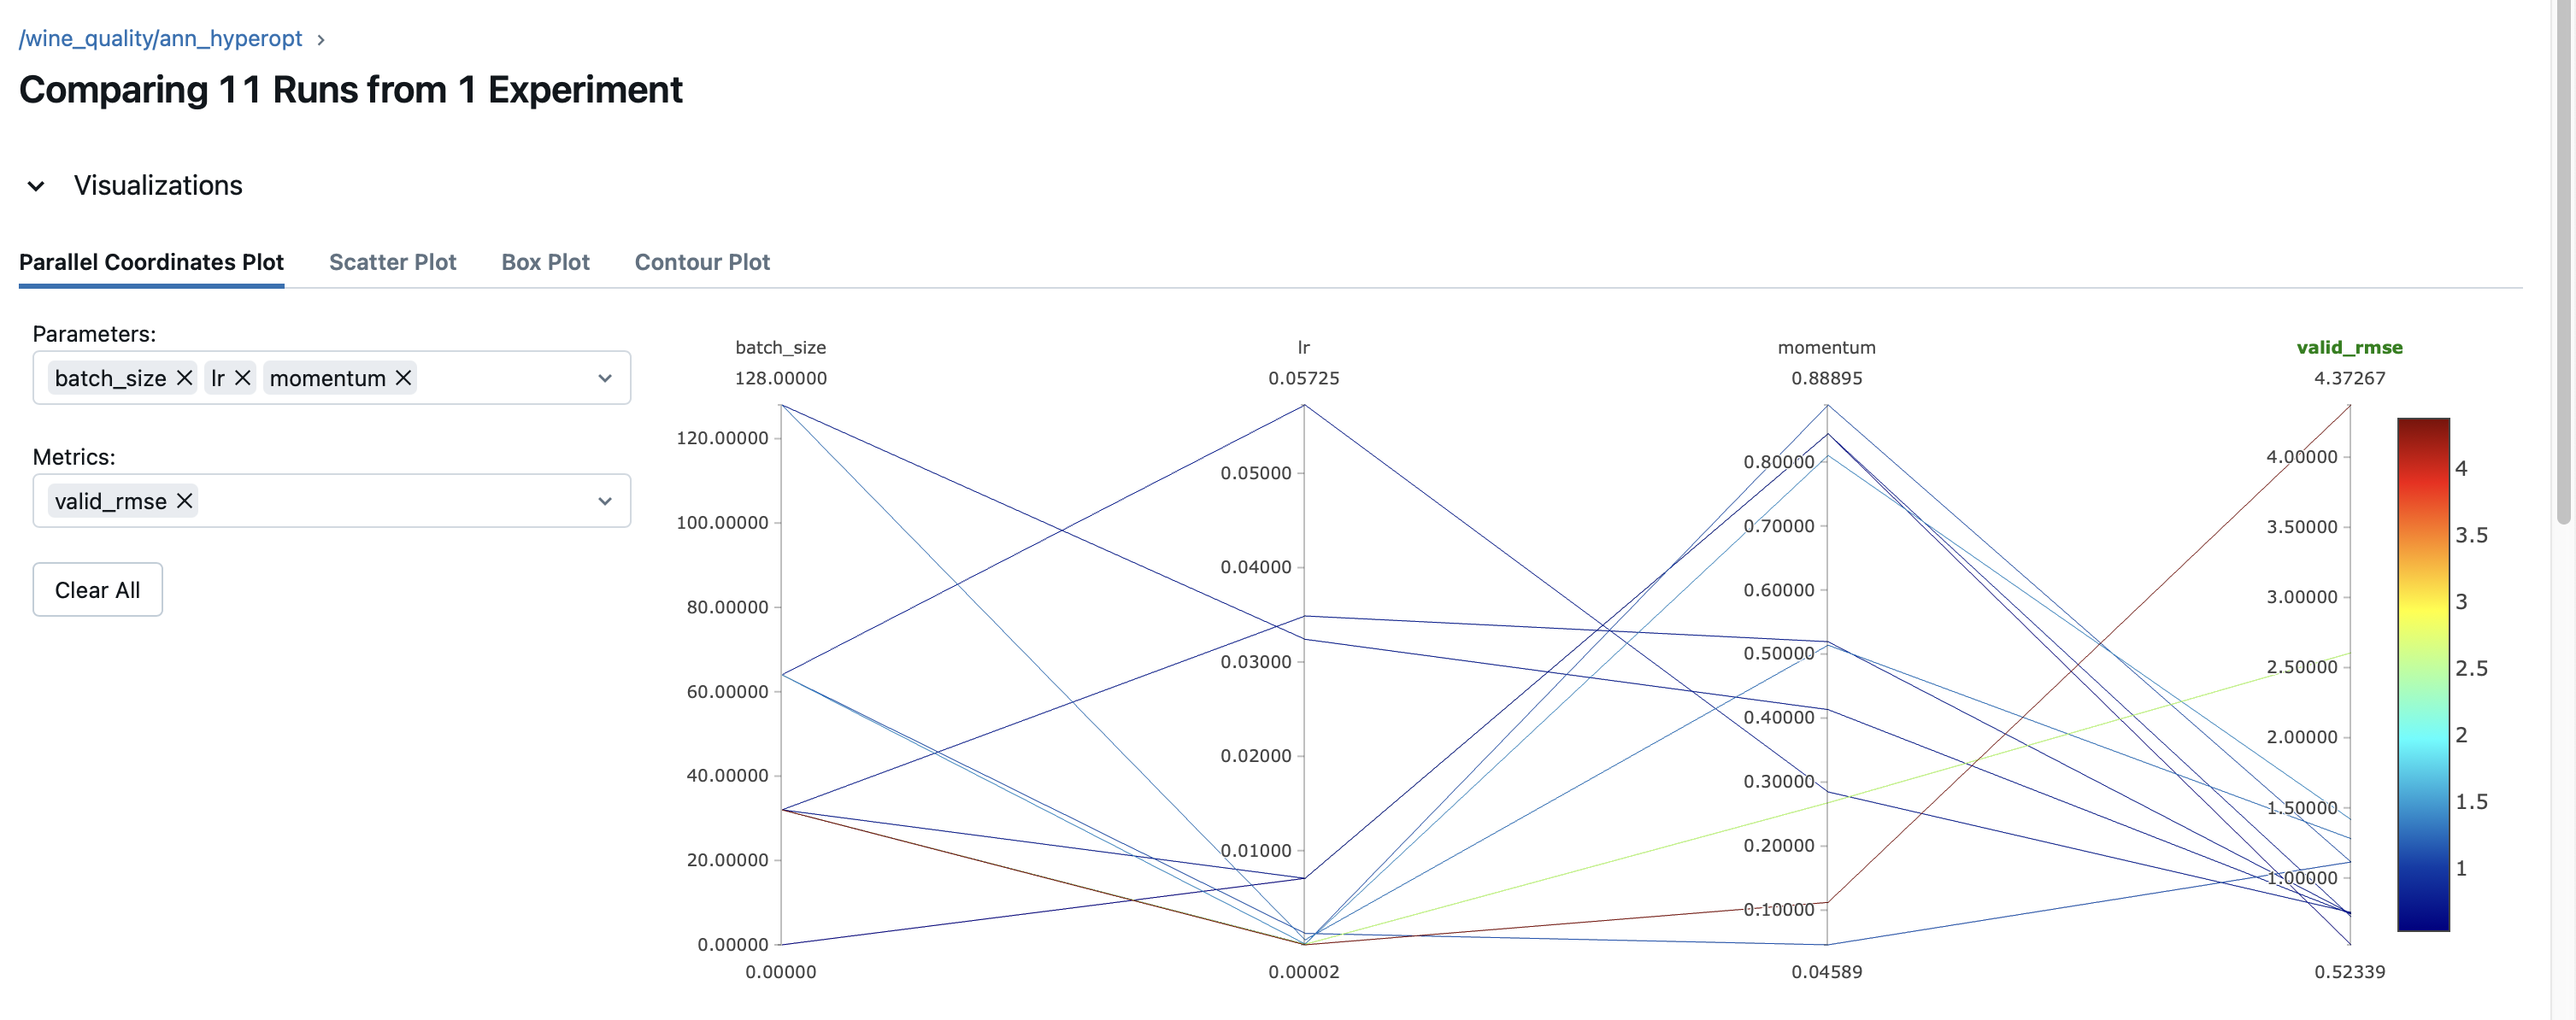


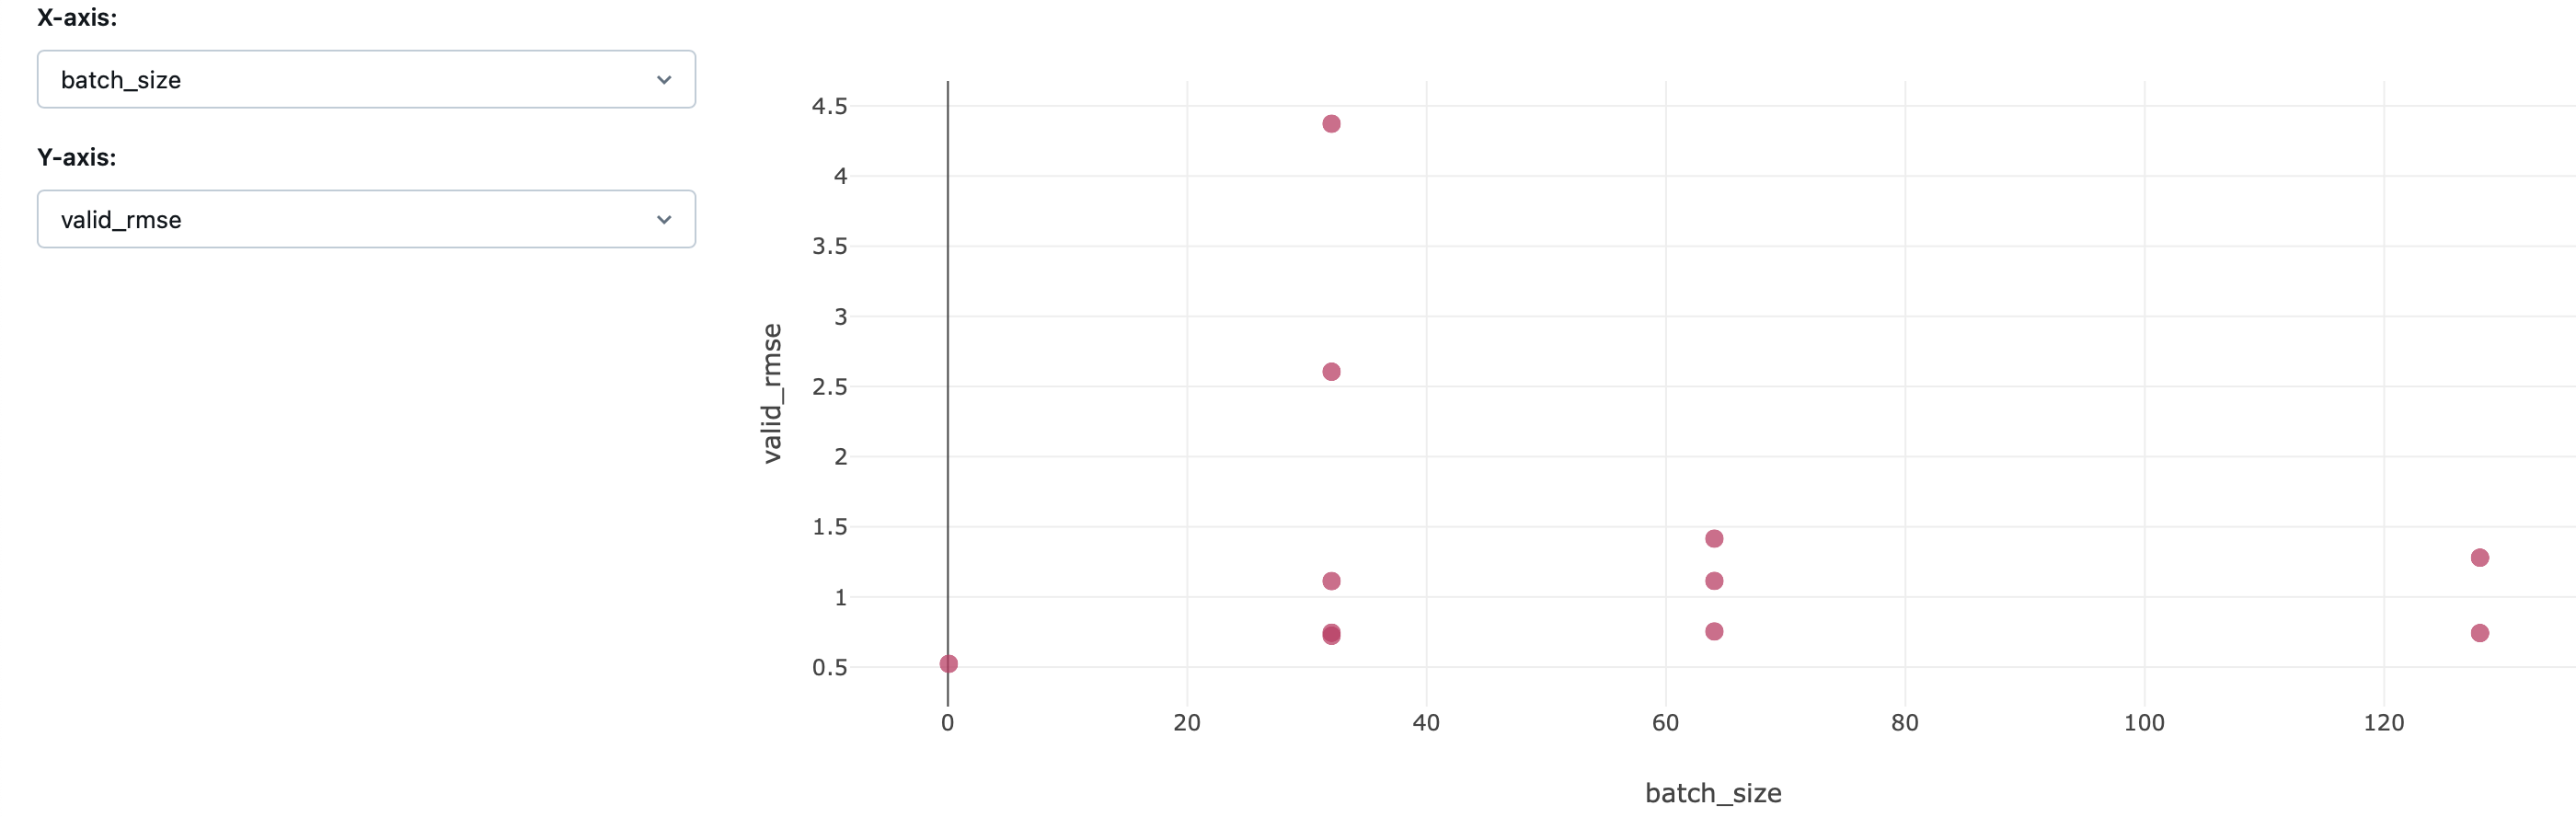


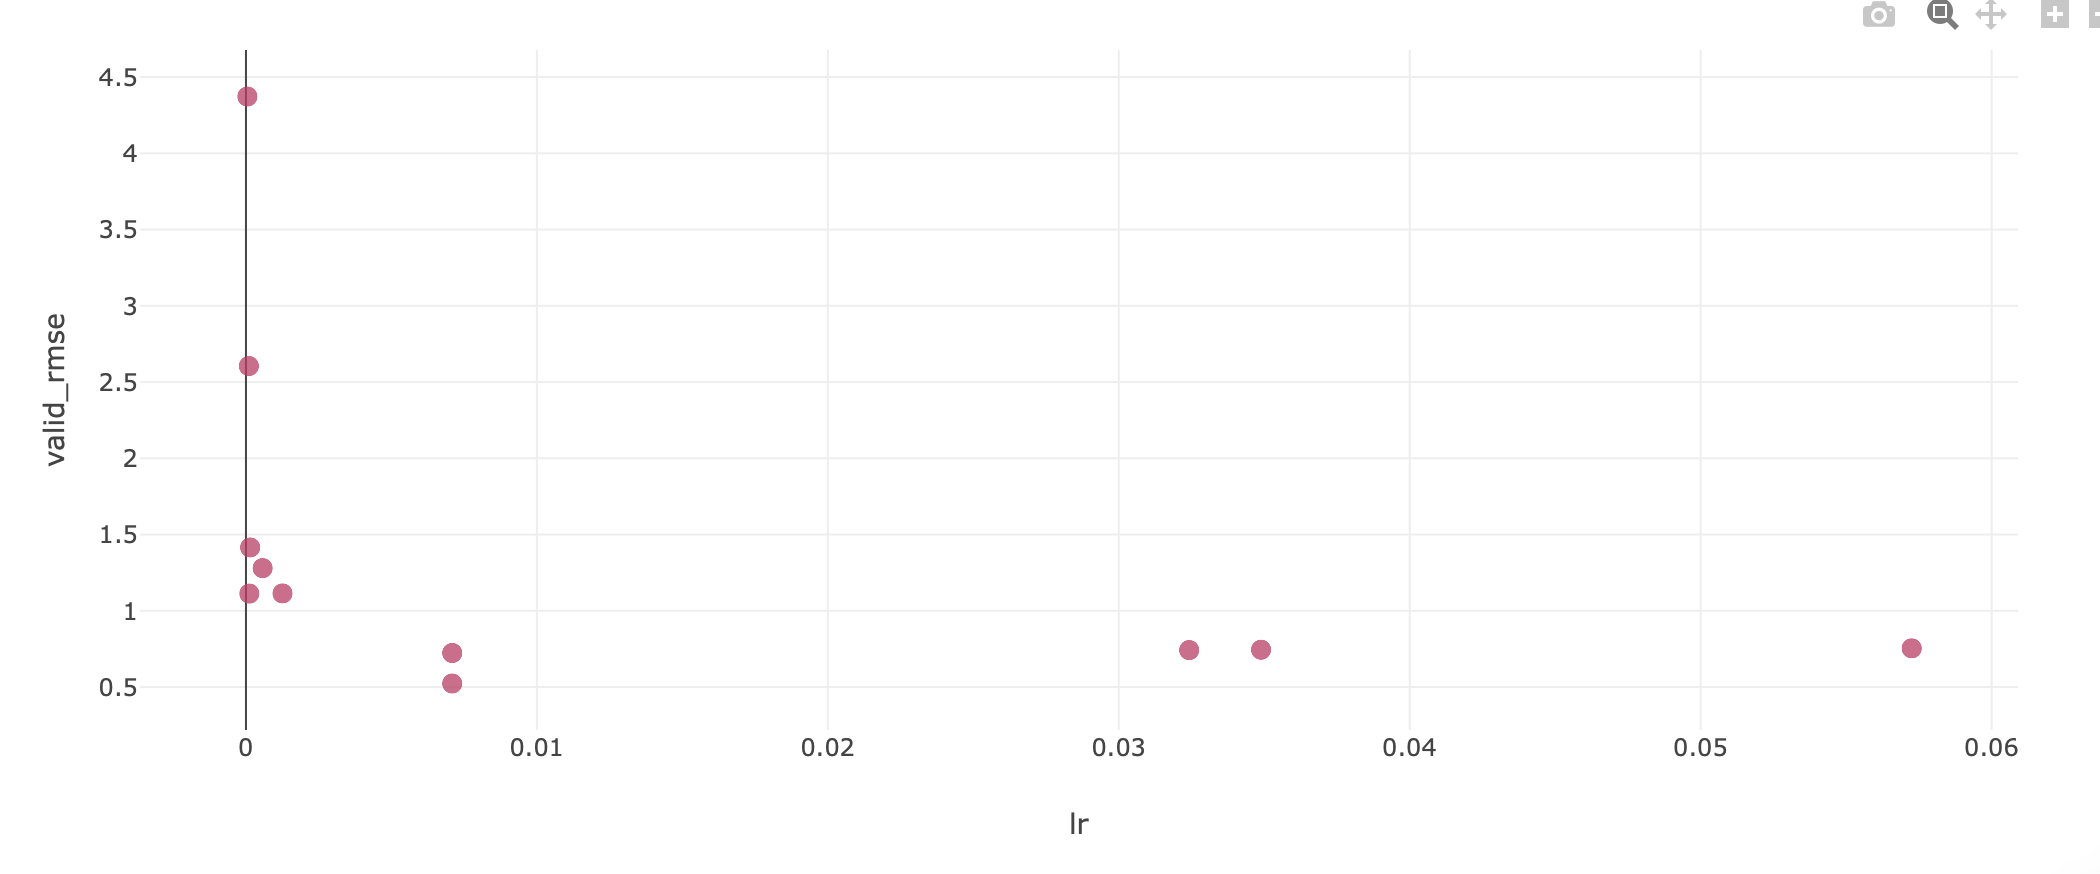


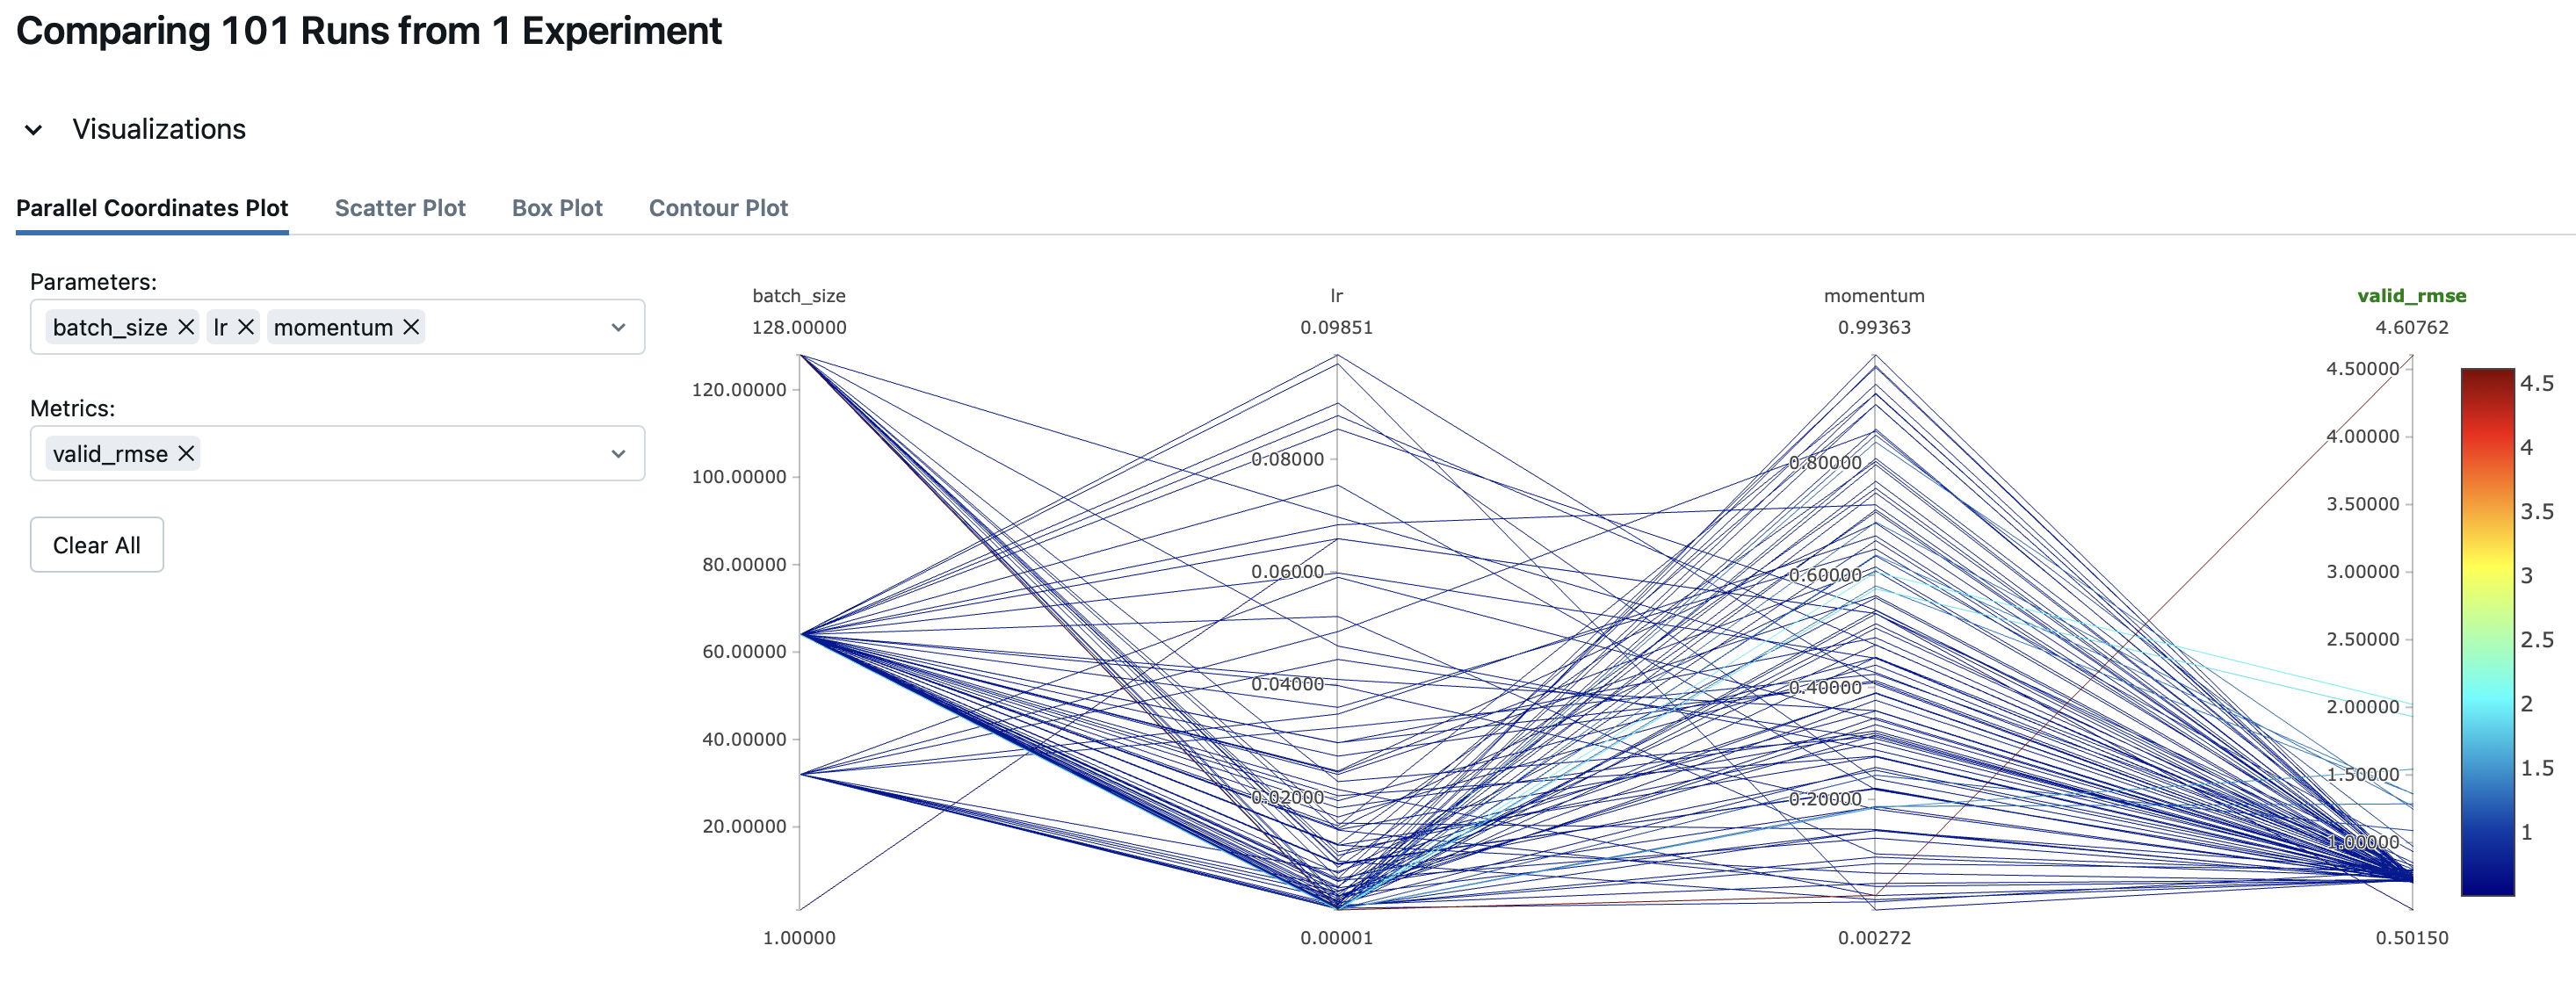


In [11]:
from mlflow.models import validate_serving_input

model_uri = 'runs:/17acdebcf921468aa4aefc596bfd8447/model'

# The logged model does not contain an input_example.
# Manually generate a serving payload to verify your model prior to deployment.
from mlflow.models import convert_input_example_to_serving_input

# Define INPUT_EXAMPLE via assignment with your own input example to the model
# A valid input example is a data instance suitable for pyfunc prediction
serving_payload = convert_input_example_to_serving_input(test_x)

# Validate the serving payload works on the model
validate_serving_input(model_uri, serving_payload)

/Users/coldbrew/Documents/MLOps_study/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step


array([[ 5.617477 ],
       [ 7.2137375],
       [ 7.011762 ],
       [ 4.4714813],
       [ 8.037432 ],
       [ 4.7848077],
       [ 4.187228 ],
       [ 7.238528 ],
       [ 5.214346 ],
       [ 7.8988686],
       [ 6.2802873],
       [ 4.9977508],
       [ 5.702217 ],
       [ 4.8521733],
       [ 4.9929476],
       [ 9.027939 ],
       [ 4.563947 ],
       [ 5.4863043],
       [ 5.467416 ],
       [ 5.55072  ],
       [ 5.991807 ],
       [ 9.115822 ],
       [ 5.0875015],
       [ 4.524084 ],
       [ 6.3851314],
       [ 5.4623637],
       [ 5.3562613],
       [ 5.986146 ],
       [ 6.8089676],
       [ 6.070915 ],
       [ 5.9291515],
       [ 6.2489457],
       [ 5.0004272],
       [ 6.8540773],
       [12.382954 ],
       [ 7.035386 ],
       [ 5.033955 ],
       [ 7.5289583],
       [ 5.726223 ],
       [ 5.243509 ],
       [ 7.67203  ],
       [ 7.589157 ],
       [ 6.1157837],
       [ 6.583727 ],
       [ 6.68239  ],
       [ 5.542872 ],
       [ 6.170151 ],
       [ 5.71

In [12]:
loaded_model = mlflow.pyfunc.load_model(model_uri)

loaded_model.predict(test_x)


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step


array([[ 5.617477 ],
       [ 7.2137375],
       [ 7.011762 ],
       [ 4.4714813],
       [ 8.037432 ],
       [ 4.7848077],
       [ 4.187228 ],
       [ 7.238528 ],
       [ 5.214346 ],
       [ 7.8988686],
       [ 6.2802873],
       [ 4.9977508],
       [ 5.702217 ],
       [ 4.8521733],
       [ 4.9929476],
       [ 9.027939 ],
       [ 4.563947 ],
       [ 5.4863043],
       [ 5.467416 ],
       [ 5.55072  ],
       [ 5.991807 ],
       [ 9.115822 ],
       [ 5.0875015],
       [ 4.524084 ],
       [ 6.3851314],
       [ 5.4623637],
       [ 5.3562613],
       [ 5.986146 ],
       [ 6.8089676],
       [ 6.070915 ],
       [ 5.9291515],
       [ 6.2489457],
       [ 5.0004272],
       [ 6.8540773],
       [12.382954 ],
       [ 7.035386 ],
       [ 5.033955 ],
       [ 7.5289583],
       [ 5.726223 ],
       [ 5.243509 ],
       [ 7.67203  ],
       [ 7.589157 ],
       [ 6.1157837],
       [ 6.583727 ],
       [ 6.68239  ],
       [ 5.542872 ],
       [ 6.170151 ],
       [ 5.71

In [29]:
# 이렇게 등록할 수 도 있음 
mlflow.register_model(model_uri, "wine_quality_ann_hyperopt")

Successfully registered model 'wine_quality_ann_hyperopt'.
Created version '1' of model 'wine_quality_ann_hyperopt'.


<ModelVersion: aliases=[], creation_timestamp=1736263977491, current_stage='None', description=None, last_updated_timestamp=1736263977491, name='wine_quality_ann_hyperopt', run_id='17acdebcf921468aa4aefc596bfd8447', run_link=None, source='file:///Users/coldbrew/Documents/MLOps_study/2-DLMLflow/mlruns/334682367187648027/17acdebcf921468aa4aefc596bfd8447/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=1>